In [72]:
import numpy as np
import pandas as pd

train = pd.read_csv("/Users/xinchengzhu/Downloads/train.csv")

In [73]:
# Filter missing data and useless columns
train = train[train["MISSING_DATA"] == False]
train = train[train["POLYLINE"].map(len) > 1]
train = train[train["POLYLINE"] != "[]"]
train = train[["POLYLINE"]]
# Choose 10000 rows randomly from dataset to run
train_1 = train.sample(10000)

train_1

,POLYLINE
378442,"[[-8.660538,41.150061],[-8.660583,41.15007],[-..."
511120,"[[-8.650125,41.153508],[-8.650116,41.153508],[..."
436783,"[[-8.652798,41.1588],[-8.652843,41.158809],[-8..."
1622970,"[[-8.639739,41.159772],[-8.639748,41.159772],[..."
675607,"[[-8.610849,41.145624],[-8.610885,41.145714],[..."
...,...
1186660,"[[-8.585676,41.148522],[-8.585667,41.148612],[..."
701233,"[[-8.610021,41.140899],[-8.609985,41.140935],[..."
27067,"[[-8.644239,41.15763],[-8.643942,41.157495],[-..."
225970,"[[-8.599311,41.149215],[-8.599293,41.14917],[-..."


In [74]:
def _change_type(polyline):
    polyline = polyline[2:-2]
    cords_raw = polyline.split("],[")
    cords = []
    max_lon, min_lon, max_lat, min_lat = float("-inf"), float("inf"), float("-inf"), float("inf")
    for cord in cords_raw:
        cords.append([float(loc) for loc in cord.split(",")])
        max_lon = max(max_lon, cords[-1][0])
        min_lon = min(min_lon, cords[-1][0])
        max_lat = max(max_lat, cords[-1][1])
        min_lat = min(min_lat, cords[-1][1])
    return pd.Series({"POLYLINE": cords, "max_lon": max_lon, "min_lon": min_lon, "max_lat": max_lat, "min_lat": min_lat})

In [88]:
def filter_map(train, max_lat, min_lat, max_long, min_long):
    changed = train["POLYLINE"].apply(_change_type)
    changed.reset_index(drop=True,inplace=True)
    changed["check"] = [0 for i in range(len(changed))]
    for i in range(len(changed)):
        for cord in changed.iloc[i]['POLYLINE']:
            if cord[0] < max_long and cord[0] > min_long and cord[1] < max_lat and cord[1] > min_lat:
                changed["check"].iloc[i] = 1
            else:
                changed["check"].iloc[i] = 0
                break
    return changed[changed["check"] == 1]
filter_map(train_1, 41.5,40,-8.6,-9)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,POLYLINE,max_lon,min_lon,max_lat,min_lat,check
0,"[[-8.660538, 41.150061], [-8.660583, 41.15007]...",-8.635023,-8.660583,41.159142,41.140800,1
1,"[[-8.650125, 41.153508], [-8.650116, 41.153508...",-8.643168,-8.650314,41.162859,41.152635,1
2,"[[-8.652798, 41.1588], [-8.652843, 41.158809],...",-8.629506,-8.656065,41.162265,41.156541,1
3,"[[-8.639739, 41.159772], [-8.639748, 41.159772...",-8.639739,-8.675478,41.159835,41.146767,1
4,"[[-8.610849, 41.145624], [-8.610885, 41.145714...",-8.601723,-8.610894,41.163705,41.145624,1
...,...,...,...,...,...,...
9990,"[[-8.639856, 41.159754], [-8.640072, 41.159817...",-8.629749,-8.654922,41.246505,41.159754,1
9991,"[[-8.627769, 41.175369], [-8.62767, 41.175261]...",-8.625240,-8.650656,41.175369,41.160231,1
9994,"[[-8.627616, 41.157702], [-8.627688, 41.157729...",-8.627148,-8.650692,41.166495,41.157702,1
9996,"[[-8.610021, 41.140899], [-8.609985, 41.140935...",-8.605116,-8.611497,41.140935,41.119209,1


In [4]:
def _normalize(polyline, max_lon, min_lon, max_lat, min_lat):
    final = [[(cord[0]-min_lon)/(max_lon-min_lon), (cord[1] - min_lat) / (max_lat - min_lat)] for cord in polyline]
    return pd.Series({"POLYLINE_INIT": final[:-1], "POLYLINE_DEST": final[-1]})

In [5]:
def _to_matrix(polyline, m):
    mat = np.zeros((m, m))
    n = len(polyline)
    for i in range(n):
        x = min(m - 1, int(polyline[i][0] * m))
        y = min(m - 1, int(polyline[i][1] * m))
        mat[y][x] = (i + 1) / n
    return mat

In [6]:
def transform(df_train, m):
    # Change type
    changed = df_train["POLYLINE"].apply(_change_type)
    df_train["POLYLINE"] = changed["POLYLINE"]
    # Get min-max
    max_longitude = changed["max_lon"].max()
    min_longitude = changed["min_lon"].min()
    max_latitude = changed["max_lat"].max()
    min_latitude = changed["min_lat"].min()
    # Normalize min-max and split
    cleaned = train_1["POLYLINE"].apply(_normalize, args=(max_longitude, min_longitude, max_latitude, min_latitude))
    # Transform to matrices
    cleaned["MATRIX"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m,))
    return cleaned

In [7]:
transformed = transform(train_1, 256)

In [8]:
import matplotlib.pyplot as plt

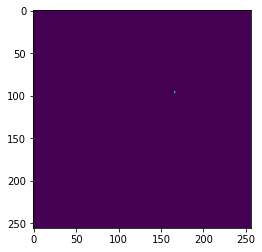

In [9]:
mat = transformed["MATRIX"].iloc[0]

plt.imshow(mat)
plt.show()

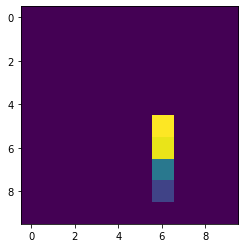

In [10]:
plt.imshow(mat[90:100, 160:170])
plt.show()

In [37]:
for i in range(len(train_1)):
    for cord in train_1.iloc[i]['POLYLINE']:
        if cord[0] in range(1, 4) and cord[1] in range(1, 5):
            pass
        else:
            train_1.drop([train_1.index[i]], inplace=True)

IndexError: index 7 is out of bounds for axis 0 with size 7

In [69]:
train_1.drop([train_1.index[0]],inplace=True)
train_1

,POLYLINE,index
1,"[[-8.630451,41.167944]]",1
2,"[[-8.585793,41.148954],[-8.586387,41.14899],[-...",2
3,"[[-8.613675,41.141556],[-8.613846,41.141142],[...",3
4,"[[-8.648217,41.154408],[-8.647191,41.155362],[...",4
5,"[[-8.589267,41.169717],[-8.589267,41.169825],[...",5
...,...,...
9995,"[[-8.614701,41.140917],[-8.614053,41.14116],[-...",9995
9996,"[[-8.609661,41.160222],[-8.609643,41.160258],[...",9996
9997,"[[-8.644932,41.162706],[-8.64495,41.162958],[-...",9997
9998,"[[-8.639991,41.159637],[-8.639955,41.159646],[...",9998


In [66]:
train_1.reset_index(drop=True,inplace=True)
train_1

,POLYLINE
0,"[[-8.628219,41.165046],[-8.62839,41.164956],[-..."
1,"[[-8.630451,41.167944]]"
2,"[[-8.585793,41.148954],[-8.586387,41.14899],[-..."
3,"[[-8.613675,41.141556],[-8.613846,41.141142],[..."
4,"[[-8.648217,41.154408],[-8.647191,41.155362],[..."
...,...
9995,"[[-8.614701,41.140917],[-8.614053,41.14116],[-..."
9996,"[[-8.609661,41.160222],[-8.609643,41.160258],[..."
9997,"[[-8.644932,41.162706],[-8.64495,41.162958],[-..."
9998,"[[-8.639991,41.159637],[-8.639955,41.159646],[..."


In [78]:
train_1["index"] = range(len(train_1))
train_1

,POLYLINE,index
378442,"[[-8.660538,41.150061],[-8.660583,41.15007],[-...",0
511120,"[[-8.650125,41.153508],[-8.650116,41.153508],[...",1
436783,"[[-8.652798,41.1588],[-8.652843,41.158809],[-8...",2
1622970,"[[-8.639739,41.159772],[-8.639748,41.159772],[...",3
675607,"[[-8.610849,41.145624],[-8.610885,41.145714],[...",4
...,...,...
1186660,"[[-8.585676,41.148522],[-8.585667,41.148612],[...",9995
701233,"[[-8.610021,41.140899],[-8.609985,41.140935],[...",9996
27067,"[[-8.644239,41.15763],[-8.643942,41.157495],[-...",9997
225970,"[[-8.599311,41.149215],[-8.599293,41.14917],[-...",9998
